<a href="https://colab.research.google.com/github/jimmYA-1995/GAN_practice/blob/master/GAN_practice_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %tensorflow_version 2.x
# 2019/09/19 For now, tensorflow_version 2.x doesn't use the latest version of tensorflow 2.
# which causes some issue, ref https://github.com/tensorflow/tensorflow/issues/32594

In [0]:
!pip install tensorflow-gpu==2.0.0-rc1

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imshow
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential, datasets, optimizers
from tensorflow.keras.datasets import mnist 



In [0]:
np.__version__

'1.16.5'

In [0]:
tf.__version__

'2.0.0-rc1'

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 32
x_train.dtype, x_train.shape, y_train.dtype, y_train.shape

(dtype('uint8'), (60000, 28, 28), dtype('uint8'), (60000,))

In [0]:
def showX(X):
    int_X_reshape = X.reshape(-1,28,28).swapaxes(0,1).reshape(28,-1)
    display(Image.fromarray(int_X_reshape))

showX(x_train[:20])

In [0]:
y_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

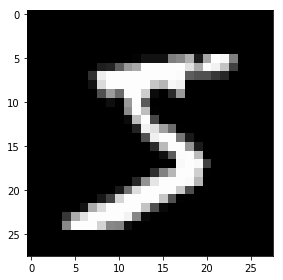

In [0]:
imshow(x_train[0])

In [0]:
def preprocess(x):
    x = (tf.cast(x, tf.float32) - 127.5) / 127.5
    return x[..., None]

ds_train_x = tf.data.Dataset.from_tensor_slices(preprocess(x_train))
ds_train_y = tf.data.Dataset.from_tensor_slices(y_train).map(lambda y: tf.one_hot(y, 10))
ds_train = tf.data.Dataset.zip((ds_train_x, ds_train_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
# Define generator
LATENT_DIM = 100
class Generator(Model):
  def __init__(self):
    super().__init__()
    self.fc1 = layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,))
    self.bn1 = layers.BatchNormalization()
    # deConV layer
    self.conv2tr_1 = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="SAME", use_bias=False)
    self.bn2 = layers.BatchNormalization()
    # deConV layer
    self.conv2tr_2 = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="SAME", use_bias=False)
    self.bn3 = layers.BatchNormalization()
    # deConV layer
    self.conv2tr_3 = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding="SAME", activation="tanh")
    
  @tf.function
  def call(self, inputs, is_training=False):
    _ = layers.concatenate([inputs[1], inputs[0]])
    x = self.fc1(_)
    x = self.bn1(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = tf.reshape(x, shape=[-1,7,7,256])
    x = self.conv2tr_1(x)
    x = self.bn2(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = self.conv2tr_2(x)
    x = self.bn3(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    
    x = self.conv2tr_3(x)
    
    return x

In [0]:
# DEFINE Descriminator
class Descriminator(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv2D(64, (5,5), strides=2, padding="SAME")
    self.drop1 = layers.Dropout(0.3)
    self.conv2 = layers.Conv2D(128, (5,5), strides=2, padding="SAME")
    self.drop2 = layers.Dropout(0.3)
    self.flatten = layers.Flatten()
    self.fc1 = layers.Dense(50)
    self.bn = layers.BatchNormalization()
    self.fc2 = layers.Dense(1)
  
  @tf.function
  def call(self, inputs, is_training=False):
    x = self.conv1(inputs[0])
    x = tf.nn.leaky_relu(x)
    x = self.drop1(x, training=is_training)
    x = self.conv2(x)
    x = tf.nn.leaky_relu(x)
    x = self.drop2(x, training=is_training)
    x = self.flatten(x)
    x = layers.concatenate([x, inputs[1]])
    x = self.fc1(x)
    x = self.bn(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = self.fc2(x)
    
    return x

In [0]:
generator = Generator()
discriminator = Descriminator()
generator.build(input_shape=[(None,10),(None,LATENT_DIM)])
discriminator.build(input_shape=[(None,28,28,1),(None,10)])

In [0]:
# Define both loss function
def generator_loss(generated_output):
  return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output, from_logits=True))

In [0]:
def discriminator_loss(real_output, generated_output):
  
  real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output, from_logits=True))
  generated_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.zeros_like(generated_output), generated_output, from_logits=True))

  total_loss = real_loss + generated_loss

  return total_loss

In [0]:
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

In [0]:
EPOCHS = 50
num_examples_to_generate = 20

# reuse this vector
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 LATENT_DIM])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

In [0]:
@tf.function
def train_step(images, labels):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator([noise, labels], is_training=True)

    real_output = discriminator([images, labels], is_training=True)
    generated_output = discriminator([generated_images, labels], is_training=True)

    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def plot_numBar(images):
  images = np.uint8(images*127.5+128).clip(0, 255)[...,0]
  concat_image = np.transpose(images, [1,0,2])
  concat_image = concat_image.reshape((28,-1))
  display(Image.fromarray(concat_image))

In [0]:
for epoch in range(15):
  start_time = time.time()
  for images, labels in ds_train:
    train_step(images, labels)
  
  fake = generator([random_vector_for_generation, condition_vector_generation], is_training=False)
  print(epoch, time.time()-start_time)
  plot_numBar(fake)

0 49.3989622592926


1 45.6253547668457


2 45.36630320549011


3 45.351794481277466


4 45.58365225791931


5 45.61301898956299


6 45.49946737289429


7 45.6049702167511


8 45.41204476356506


9 45.54000735282898


10 45.704153537750244


11 45.49570941925049


12 45.48928713798523


13 45.716166734695435


14 45.385292291641235


In [0]:
MODEL_PATH = 'drive/My Drive/Colab Notebooks/mount/models/mnist_GAN/alldata'
generator.save_weights(MODEL_PATH, save_format='tf')

In [0]:
# load & use model
new_model = Generator()
new_model.build(input_shape=[(None,LATENT_DIM),(None,10)])
noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
image, label = next(iter(ds_train))

# before load weights
bad_images = generator([noise, labels], is_training=True)
plot_numBar(bad_images)

(32, 28, 28, 1)
(32, 28, 28)


In [0]:
new_model.load_weights(MODEL_PATH)

my_label = list([3,1,2,5,4,8,7,9,0,6])
noise = tf.random.normal([len(my_label), LATENT_DIM])
my_label = tf.one_hot(my_label, 10)

better = generator([noise, my_label])

plot_numBar(better)